# layout detection

In [ ]:
from surya.detection import batch_text_detection
from surya.layout import batch_layout_detection
from surya.model.detection.segformer import load_model, load_processor
from surya.model.recognition.model import load_model as load_rec_model
from surya.model.recognition.processor import load_processor as load_rec_processor
from surya.model.ordering.processor import load_processor as load_order_processor
from surya.model.ordering.model import load_model as load_order_model
from surya.ordering import batch_ordering
from surya.postprocessing.heatmap import draw_polys_on_image
from surya.ocr import run_ocr
from surya.postprocessing.text import draw_text_on_image
from PIL import Image
from surya.languages import CODE_TO_LANGUAGE
from surya.input.langs import replace_lang_with_code
from surya.schema import OCRResult, TextDetectionResult, LayoutResult, OrderResult
from surya.settings import settings


def load_det_cached():
    checkpoint = settings.DETECTOR_MODEL_CHECKPOINT
    return load_model(checkpoint=checkpoint), load_processor(checkpoint=checkpoint)


def load_rec_cached():
    return load_rec_model(), load_rec_processor()


def load_layout_cached():
    return load_model(checkpoint=settings.LAYOUT_MODEL_CHECKPOINT), load_processor(checkpoint=settings.LAYOUT_MODEL_CHECKPOINT)

def load_order_cached():
    return load_order_model(), load_order_processor()


det_model, det_processor = load_det_cached()
rec_model, rec_processor = load_rec_cached()
layout_model, layout_processor = load_layout_cached()
order_model, order_processor = load_order_cached()


In [ ]:
import pymupdf as fitz
from pymupdf import Document
def get_image_from_page(doc, page):
    page = doc[page]
    dpi = 72
    zoom = dpi / 72  # 72 is the default DPI
    mat = fitz.Matrix(zoom, zoom)
    pix = page.get_pixmap(matrix=mat)
    img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)
    return img

In [ ]:
for page in range(len(doc)):
    print(page)

In [ ]:
from typing import List, Tuple
from surya.postprocessing.heatmap import draw_polys_on_image
from surya.schema import OCRResult, TextDetectionResult, LayoutResult, OrderResult
from PIL import Image
from surya.ordering import batch_ordering


def texts_detection(images: List[Image.Image], batch_size=10) -> List[TextDetectionResult]:
    preds = batch_text_detection(images, det_model, det_processor, batch_size=batch_size)
    return preds

def layout_detection(images: List[Image.Image], batch_size=10) -> List[LayoutResult]:
    _det_preds = texts_detection(images, batch_size=batch_size)
    preds = batch_layout_detection(images, layout_model, layout_processor, _det_preds, batch_size=batch_size)
    return preds

def order_detection(images: List[Image.Image], batch_size=10) -> List[Tuple[Image.Image, OrderResult]]:
    layout_preds = layout_detection(images, batch_size=batch_size)
    all_bboxes = []
    for layout_pred in layout_preds:
        bboxes = [l.bbox for l in layout_pred.bboxes]
        all_bboxes.append(bboxes)
    preds = batch_ordering(images, all_bboxes, order_model, order_processor, batch_size=batch_size)
    all_polys = []
    all_positions = []
    for pred in preds:
        polys = [l.polygon for l in pred.bboxes]
        all_polys.append(polys)
        positions = [str(l.position) for l in pred.bboxes]
        all_positions.append(positions)

    order_imgs = []
    for idx, img in enumerate(images):
        order_img = draw_polys_on_image(all_polys[idx], img.copy(), labels=all_positions[idx], label_font_size=20)
        order_imgs.append(order_img)

    return order_imgs, preds

def process_pdf_texts(doc: type[Document]):
    batch_size = 2
    images = [get_image_from_page(doc, page_number) for page_number in range(len(doc))]
    print(images)
    order_imgs, preds = order_detection(images, batch_size=5)
    return order_imgs, preds


pdf_path = "./data/UniversScience/revue-decouverte/decouverte_436.pdf"
doc = fitz.open(pdf_path)
order_imgs, preds = process_pdf_texts(doc)


In [ ]:
# # preds[0].bboxes
# for img in order_imgs:
#     display(img)

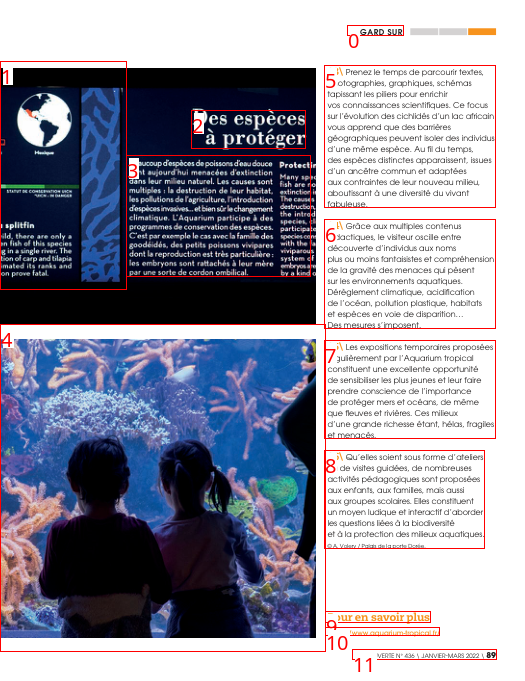

PAGEWIDTH 524.4085083007812 525
POSITION: 0
Extracted text: REGARD SUR 


PAGEWIDTH 524.4085083007812 525
POSITION: 1
Extracted text: 


PAGEWIDTH 524.4085083007812 525
POSITION: 2
Extracted text: 


PAGEWIDTH 524.4085083007812 525
POSITION: 3
Extracted text: 


PAGEWIDTH 524.4085083007812 525
POSITION: 4
Extracted text: 


PAGEWIDTH 524.4085083007812 525
POSITION: 5
Extracted text: 23\   Prenez le temps de parcourir textes,  photographies, graphiques, schémas  tapissant les piliers pour enrichir   vos connaissances scientifiques. Ce focus  sur l’évolution des cichlidés d’un lac africain  vous apprend que des barrières  géographiques peuvent isoler des individus  d’une même espèce. Au fil du temps,   des espèces distinctes apparaissent, issues  d’un ancêtre commun et adaptées   aux contraintes de leur nouveau milieu,  aboutissant à une diversité du vivant  fabuleuse. 


PAGEWIDTH 524.4085083007812 525
POSITION: 6
Extracted text: 24\   Grâce aux multiples contenus  didactiques, le visit

In [28]:
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import io
import pymupdf as fitz

page_index = 90
page = doc[page_index]
# Extract text from the specified bounding box

display(order_imgs[page_index])
for box in sorted(preds[page_index].bboxes, key=lambda x: x.position):    
    left, top, right, bottom = box.bbox
    text = page.get_text("text", clip=box.bbox)
    width = order_imgs[page_index].width
    page_rect = page.rect
    page_width = page_rect.width
    page_height = page_rect.height
    print("PAGEWIDTH", page_width, width)

    print("POSITION:", box.position)
    print("Extracted text:", text.replace('\n', ' '))
    print("\n===================\n")